- CNN: 이미지 분류 뿐만 아니라 피처 추출에 사용 가능
- 시계열 input의 피쳐를 추출하여 LSTM으로 학습 -> 인코더 역할
- 정확한 값보다는 흐름 파악에 주로 쓰임

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

from numpy.random import seed
seed(1)
from pandas import DataFrame

dtypes = {'IsCanceled': 'float64',}

# 데이터를 받아서 그려주는 함수
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# input 데이터 확인

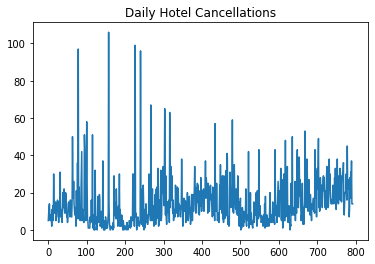

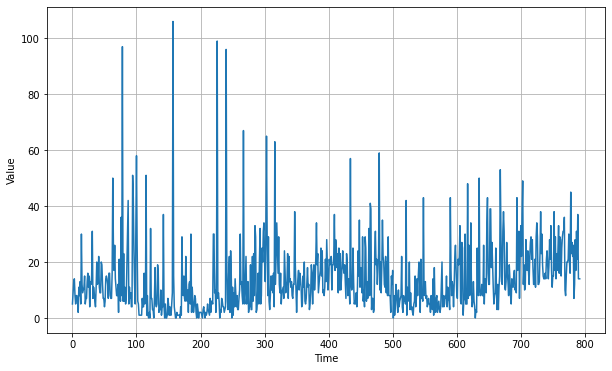

In [2]:
df = pd.read_csv('/content/drive/MyDrive/input/daily cancellations h1.csv', dtype=dtypes)
series = df['IsCanceled']
series = np.array(series)
plt.plot(series)
plt.title('Daily Hotel Cancellations')
plt.show()
time = np.arange(0, 793)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# 데이터 분할

In [4]:
split_time = 634
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# 전처리

In [5]:
# 1D-Conv layer로 전처리
keras.backend.clear_session()

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

# 모델 만들기

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='causal',
                            activation='relu')
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
keras.layers.LSTM(32, return_sequences=True),
keras.layers.Dense(1)
keras.layers.Lambda(lambda x: x*200)

optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer,
              loss=keras.losses.Huber(),
              metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h6', save_best_only=True
)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
5/5 [==============================] - 17s 188ms/step - loss: 12.2785 - mae: 12.7693 - val_loss: 19.4263 - val_mae: 19.9263
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
Epoch 2/500
5/5 [==============================] - 0s 21ms/step - loss: 12.0467 - mae: 12.5357 - val_loss: 19.1345 - val_mae: 19.6345
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
Epoch 3/500
5/5 [==============================] - 0s 22ms/step - loss: 11.8254 - mae: 12.3131 - val_loss: 18.7869 - val_mae: 19.2869
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
Epoch 4/500
5/5 [==============================] - 0s 22ms/step - loss: 11.5665 - mae: 12.0538 - val_loss: 18.3317 - val_mae: 18.8317
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
Epoch 5/500
5/5 [==============================] - 0s 23ms/step - loss: 11.2362 - mae: 11.7242 - val_loss: 17.7074 - val_mae: 18.2074
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
Epoch 6/500
5/5 [================

# 학습 및 결과값 도출

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

Epoch 1/100
5/5 [==============================] - 0s 10ms/step - loss: 4.2094 - mae: 4.6378
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 4.1956 - mae: 4.6258
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 4.1740 - mae: 4.6046
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 4.1504 - mae: 4.5796
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 4.1364 - mae: 4.5667
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 4.1389 - mae: 4.5740
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 4.1087 - mae: 4.5405
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 4.0859 - mae: 4.5165
Epoch 9/100
5/5 [==============================] - 0s 11ms/step - loss: 4.0667 - mae: 4.4964
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 4.0398 - mae: 4.4670
Epoch 11/100
5/5 [==============================] - 0s 10ms/step - loss:

KeyError: ignored

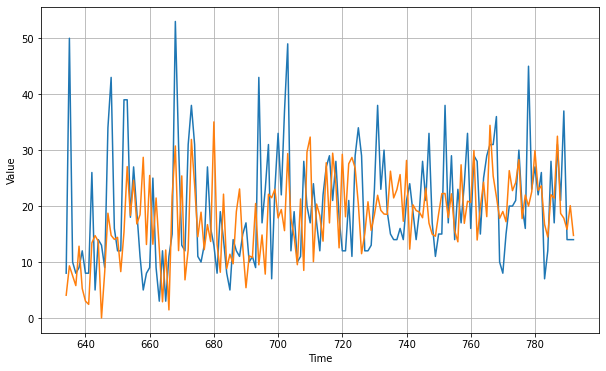

In [11]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)
model.fit(train_set, epochs=100)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])